In [1]:
import heeps
from heeps.pupil.create_lyotstop import create_ls
from heeps.optics import detector
from heeps.util.img_processing import resize_img, pad_img
from heeps.util.multiCPU import multiCPU
from copy import deepcopy
import proper
from scipy.interpolate import interp2d
from astropy.io import fits
import astropy.convolution as astroconv
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

### Inputs

In [2]:
os.chdir(os.path.normpath(os.path.expandvars('$HOME/heeps_metis/input_files/pupil')))
maskM1 = fits.getdata('eso/mask_fullM1.fits')
spiders = fits.getdata('eso/SpiderShadow.fits')
nimg = 10526                # size of the high-res pupil image
phot_spiders_L = 3.5        # pixels on the spiders (for 1 inside the pupil)
phot_spiders_N = 4.3
phot_envirnt_L = 4.3        # pixels outside the pupil (for 1 inside the pupil)
phot_envirnt_N = 5.1
spi_width = 0.54            # spider width in m
pupil_img_size = 39.9988    # pupil image in m
# nominal diameters
diam_nominal_ext = 38.542
diam_nominal_int = 10.952
# all-glass diameters
diam_allglass_ext = 36.905
diam_allglass_int = 11.213
# averaged full-M1 diameters
diam_fullM1_ext = 37.812
diam_fullM1_int = 10.196
# LMS diameters in mm
diam_nominal_LMS = 28
pupil_img_size_LMS = diam_nominal_LMS*pupil_img_size/diam_nominal_ext
# Huygens PSF data
data = 'pupil_blurring/LMS_3_worstcase_pp7.txt'
data_spacing = 0.014239     # in mm


### Background thermal emission

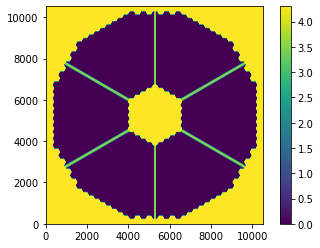

In [3]:
filename = 'pupil_blurring/background_emission_L.fits'
if os.path.isfile(filename):
    pup = fits.getdata(filename)
else:
    pup = maskM1*((1 - spiders)*phot_spiders_L) + (1 - maskM1)*phot_envirnt_L
    fits.writeto(filename, pup, overwrite=True)
plt.imshow(pup, origin='lower'); plt.colorbar();

### Huygens PSF

nkernel = 127


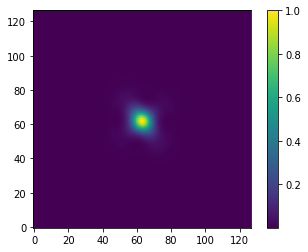

In [4]:
kernel = np.loadtxt(data , delimiter='\t', encoding='utf-16', skiprows=21)
kernel = np.delete(kernel, 0, 0)
kernel = np.delete(kernel, 0, 1)
nkernel = kernel.shape[0]
kernel_size = nkernel*data_spacing
plt.imshow(kernel, origin='lower'); plt.colorbar();
print('nkernel = %s'%nkernel)

### Convolve

npupil_LMS = 2041


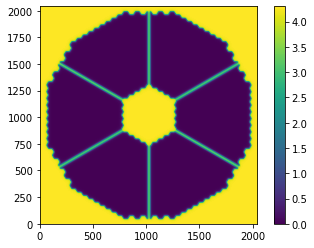

In [5]:
npupil_LMS = int(np.ceil(nkernel*pupil_img_size_LMS/kernel_size))
filename = 'pupil_blurring/pup_conv_L.fits'
if os.path.isfile(filename):
    pup_conv = fits.getdata(filename)
else:
    pup_conv = astroconv.convolve(resize_img(pup, npupil_LMS), kernel, boundary='extend')
    fits.writeto(filename, pup_conv, overwrite=True)
plt.imshow(pup_conv, origin='lower'); plt.colorbar();
print('npupil_LMS = %s'%npupil_LMS)

### Pupil image (log scale), with all-glass limits marked

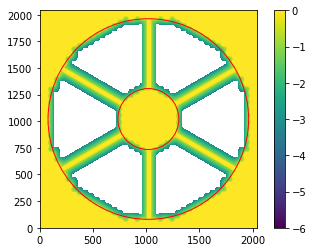

In [6]:
figure, ax = plt.subplots()
c = pup_conv.shape
ax.add_patch(plt.Circle((c[0]/2, c[1]/2), (pup_conv.shape[0]/pupil_img_size)*(diam_allglass_ext/2), color='red', fill=False))
ax.add_patch(plt.Circle((c[0]/2, c[1]/2), (pup_conv.shape[0]/pupil_img_size)*(diam_allglass_int/2), color='red', fill=False))
plt.imshow(np.log10(pup_conv), origin='lower')
plt.clim(0, -6)
plt.colorbar()
plt.savefig('pupil_blurring/pup_conv_log_scale.png', dpi=300, transparent=True)

### Blurred part of the pupil image

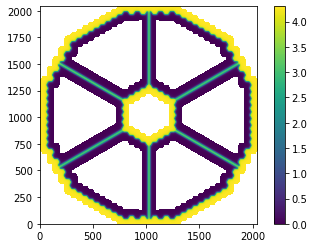

In [7]:
pup_conv = np.where(pup_conv==phot_envirnt_L, np.nan, pup_conv)
pup_conv = np.where(pup_conv==phot_spiders_L, np.nan, pup_conv)
pup_conv = np.where(pup_conv==0, np.nan, pup_conv)
figure, ax = plt.subplots()
#c = pup_conv.shape
#ax.add_patch(plt.Circle((c[0]/2, c[1]/2), (pup_conv.shape[0]/pupil_img_size)*(diam_allglass_ext/2), color='red', fill=False))
#ax.add_patch(plt.Circle((c[0]/2, c[1]/2), (pup_conv.shape[0]/pupil_img_size)*(diam_allglass_int/2), color='red', fill=False))
plt.imshow(pup_conv, origin='lower'); plt.colorbar()
plt.set_cmap('viridis')
plt.savefig('pupil_blurring/blurred_part_pup_conv.png', dpi=300, transparent=True);

### Initialize wavefront using PROPER

In [8]:
conf = dict(
    band = 'L',
    mode = 'ELT',
    dir_output = 'input_files/pupil/pupil_blurring',
    f_pupil = 'pupil/ELT_fullM1.fits',
    f_lyot_stop = '',
)
conf = heeps.config.read_config(verbose=False, **conf)
conf = heeps.config.update_config(saveconf=True, verbose=True, **conf) 
wf = heeps.pupil.pupil(savefits=True, norm_I=False, verbose=True, **conf)
pup_conv = resize_img(np.float32(pup_conv), conf['npupil'])

Simulation config: band=L, mode=ELT
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   npupil=285, pscale=5.47 mas, lam=3.8112E-06 m
   hfov=1.1 arcsec (-> ndet=403, 51.74 lam/D)

Load pupil from 'ELT_fullM1.fits'


### Relative background flux

In [9]:
def flux_thruput(r_pup, r_spi, verbose=False):
    # create lyot stop
    conf.update(ls_dRext=r_pup, ls_dRint=r_pup, ls_dRspi=r_spi)
    ls = create_ls(diam_allglass_ext, diam_allglass_int, 
            circ_ext=False, circ_int=False, **conf)
    # background flux
    overlay = pup_conv*ls
    flux = np.nansum(overlay)
    # throughput
    wf1 = deepcopy(wf)
    proper.prop_multiply(wf1, pad_img(ls, conf['ngrid']))
    psf = detector(wf1, verbose=verbose, **conf)
    thruput = np.sum(psf)
    return flux, thruput

In [10]:
filename = 'pupil_blurring/rel_flux.fits'
npup = 31
nspi = 31
rp = np.linspace(0, 0.06, npup)
rs = np.linspace(0, 0.06, nspi)
if os.path.isfile(filename):
    flux = fits.getdata('pupil_blurring/flux.fits')
    thruput = fits.getdata('pupil_blurring/thruput.fits')
    rel_flux = fits.getdata('pupil_blurring/rel_flux.fits')
else:
    flux, thruput = multiCPU(flux_thruput, 
        posvars=[np.repeat(rp, nspi), np.tile(rs, npup)], nout=2)
    flux = flux.reshape(npup, nspi)
    thruput = thruput.reshape(npup, nspi)
    # fraction of background flux relative to flux from pupil
    rel_flux = flux/thruput
    fits.writeto('pupil_blurring/flux.fits', flux)
    fits.writeto('pupil_blurring/thruput.fits', thruput)
    fits.writeto('pupil_blurring/rel_flux.fits', rel_flux)

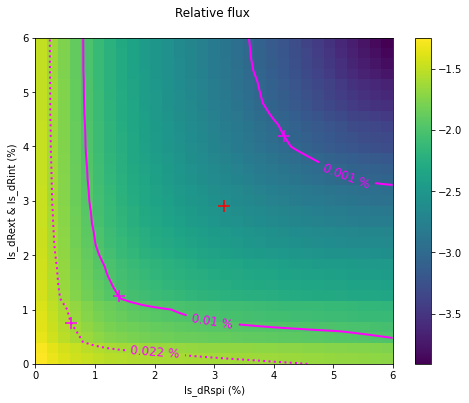

In [11]:
fig, ax = plt.subplots(figsize = (8,6))
plt.imshow(np.log10(rel_flux), origin='lower', aspect='auto', cmap='viridis', 
    extent=(rs[0],rs[-1],rp[0],rp[-1]))
plt.colorbar()
CS = ax.contour(np.log10(rel_flux), [-3, -2, np.log10(0.0222)], 
    colors='magenta', linewidths=2, linestyles=['-','-',':'], 
    extent=(rs[0],rs[-1],rp[0],rp[-1]))
for c in CS.collections:
    v = c.get_paths()[0].vertices
    x = v[:,0]
    y = v[:,1]
    f = interp2d(rs, rp, thruput)
    for s,p in zip(rs,rp):
        t = np.array([f(s,p) for s,p in zip(x,y)])
    i = np.argmax(t)
    plt.scatter(x[i], y[i], s=150, c='magenta', marker='+')

def fmt(x):
    x = 10**x
    s = f"{x:.3f}"
    if s.endswith("0"):
        s = f"{x:.2f}"
    return rf"{s} \%" if plt.rcParams["text.usetex"] else f"{s} %"
ax.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=12, 
    manual=[(5e-2,3e-2),(3e-2,1e-2),(2e-2,0e-2)])

plt.scatter(0.0317, 0.0291, s=150, c='red', marker='+')
plt.ylabel('ls_dRext & ls_dRint (%)');
plt.xlabel('ls_dRspi (%)');
plt.title('Relative flux \n ');
ax.set_xticklabels([0,1, 2, 3, 4, 5, 6])
ax.set_yticklabels([0,1, 2, 3, 4, 5, 6])
plt.savefig('pupil_blurring/2D_map_rel_bgrd_flux.png', dpi=300, transparent=True)

